In [4]:
import numpy as np
import os
import os.path
import src.visualization.display as dsp
import netCDF4 as nc
import matplotlib.pyplot as plt
import torch
from pytorch_lightning import Trainer,seed_everything,LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import src.unet as unet
import scipy.ndimage.morphology as scm
import importlib
import matplotlib.ticker as mtick
from scipy import interpolate
importlib.reload(dsp)

/Users/coulaud/opt/anaconda3/envs/DL-normalization/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'src.visualization.display' from '/Users/coulaud/Documents/DL-normalization/src/visualization/display.py'>

In [7]:
os.getcwd()
os.chdir("..")
os.getcwd()

'/Users/coulaud/Documents/DL-normalization'

In [6]:
ls ../data

lats.txt   lons.txt   processed/ raw/


In [3]:
ls ../data/processed

demo_isotropic_noise3_samples_normalize/
demo_isotropic_noise3_samples_standardize/
isotropic_noise100_samples_standardize/
isotropic_noise99_samples_standardize/
nemo_perten90_samples_standardize copie/
nemo_perten90_samples_standardize copie.zip


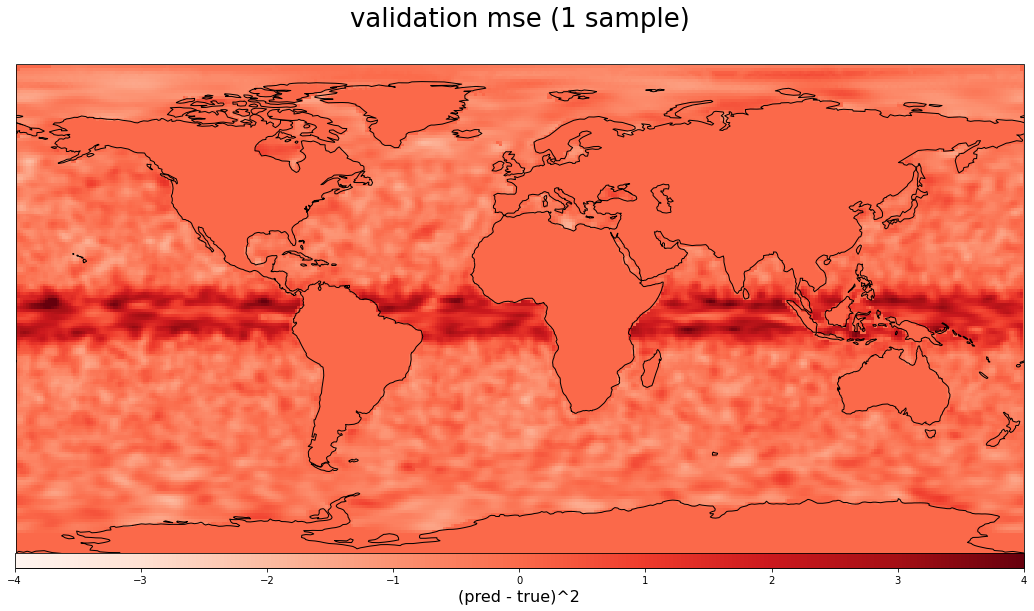

In [12]:
nemo_lats = np.loadtxt("data/lats.txt")[1:-1,1:-1]
nemo_lons = np.loadtxt("data/lons.txt")[1:-1,1:-1]

lon = np.arange(-180, 180)
lat = np.arange(-90, 90)
lon2d, lat2d = np.meshgrid(lon, lat)

X = np.load("data/processed/nemo_perten90_samples_standardize copie//valid/X/NORSSH_PERTEN15.npz")['arr_0']

points_nemo = []
points_mercator = []

pad = 10

pad_lons = np.empty((290,360 + 2 * pad))
pad_lons[:,pad:-pad] = np.copy(nemo_lons)
pad_lons[:,:pad] = np.copy(pad_lons[:,-2*pad:-pad])
pad_lons[:,-pad:] = np.copy(pad_lons[:,pad:2*pad])

pad_lats = np.empty((290,360 + 2 * pad))
pad_lats[:,pad:-pad] = np.copy(nemo_lats)
pad_lats[:,:pad] = np.copy(pad_lats[:,-2*pad:-pad])
pad_lats[:,-pad:] = np.copy(pad_lats[:,pad:2*pad])

for i in range(len(pad_lons)):
    for j in range(len(pad_lons[0])):
        points_nemo.append((pad_lons[i,j],pad_lats[i,j]))

        
for i in range(-90,90):
    for j in np.concatenate((np.arange(-10,180),np.arange(-180,10))):
        points_mercator.append((j,i))

padded=np.copy(X[0,20:-20,10:-10])
interp1 = np.nan_to_num(interpolate.griddata(points_nemo,padded.flatten(), 
                                            points_mercator)).reshape((180,380))


dsp.plot_error_globe(interp1[:,10:-10], lon2d, lat2d,vmin=-4,vmax=4,cmap="Reds",
                     cmap_title="(pred - true)^2",title="validation mse (1 sample)")

In [9]:
X.shape

(3, 330, 400)